# Forecasting the Price of Coffee Using Time-series and Machine Learning Techniques

## Framing & Background

__Executive Summary:__ This project aims to accurately forecast the price / lb of coffee.  Commodity data is pulled from csv files via macrotrends.net.  After joining the different dataframes, autoregressive integrated moving average (ARIMA) and Random Forrestf models are utilized to forecast the price of coffee.  The accuracy of these models are measured by root mean squared error (RMSE) and benchmarked to a simple carry forward model.  The results show that the random forest model performs much better than the ARIMA model but only slightly better than the benchmark.  This moderate performance likely stems from a lack of quality data that drives coffee prices.  Acquiring weather data from key coffee exporters will likely significantly enhance the model's performance. 


__Hypothesis:__ The hypothesis of this analysis aims to test whether coffee prices can be accurately predicted.  

__Problem Overview:__ Over $100B of coffee is traded annually each year.  This makes it second only to oil as the most-sought-after commodity on the planet. Investment firms, coffee farmers, and beverage giants all need to accurately project the price of coffee so they can maximize their profits.  The objective of this project is to utilize disparate data sets and create a machine learning model to precisely predicte the price/lb of coffee.  

__Target Variable & Importance:__ The price/lb of coffee in US dollars is the target variable. This model could be utilized by two types of organizations.  First, investment firms could harness the predictive power of the model for arbitrage. Identifying future contracts that diverge significantly from the model could lead to investment opportunities.  Second, corporations who purchase large amounts of coffee could use this model to lock in favorable prices using futures contracts. Ultimately, this would save firm's money and thus improve their profits.   

## Data Preparation

In [213]:
#Reading datasets and other packages

import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path
import statsmodels as sm

coffee = Path('..', 'Final Project', 'Datasets', 'historic_coffee_prices.csv') 
coffee = pd.read_csv(coffee)

corn = Path('..', 'Final Project', 'Datasets', 'historic_corn_prices.csv') 
corn = pd.read_csv(corn)

cotton = Path('..', 'Final Project', 'Datasets', 'historic_cotton_prices.csv') 
cotton = pd.read_csv(cotton)

sugar = Path('..', 'Final Project', 'Datasets', 'historic_sugar_prices.csv') 
sugar = pd.read_csv(sugar)

wheat = Path('..', 'Final Project', 'Datasets', 'historic_wheat_prices.csv') 
wheat = pd.read_csv(wheat)

In [214]:
#Changing column names

coffee.rename(columns = {coffee.columns[1]: 'coffee_prices'}, inplace=True)
corn.rename(columns = {corn.columns[1]: 'corn_prices'}, inplace=True)
cotton.rename(columns = {cotton.columns[1]: 'cotton_prices'}, inplace=True)
sugar.rename(columns = {sugar.columns[1]: 'sugar_prices'}, inplace=True)
wheat.rename(columns = {wheat.columns[1]: 'wheat_prices'}, inplace=True)

In [215]:
#Merge the dataframes

from functools import reduce
dfs = [coffee, corn, cotton, sugar, wheat]
commodities = reduce(lambda left,right: pd.merge(left,right,on='date'), dfs)


In [216]:
commodities.loc[:, 'date'] = pd.to_datetime(commodities.loc[:, 'date'])
commodities.set_index('date', inplace=True)

coffee.loc[:, 'date'] = pd.to_datetime(coffee.loc[:, 'date'])
coffee.set_index('date', inplace=True)

In [217]:
commodities.head()

,coffee_prices,corn_prices,cotton_prices,sugar_prices,wheat_prices
date,,,,,
1973-08-20,0.6735,3.115,0.7800,0.0852,5.085
1973-08-21,0.6710,3.015,0.7925,0.0859,5.285
1973-08-22,0.6580,2.915,0.8100,0.0870,5.085
1973-08-23,0.6675,2.815,0.8300,0.0880,5.005
1973-08-24,0.6660,2.900,0.8500,0.0886,5.180


In [218]:
coffee.head()

,coffee_prices
date,
1973-08-20,0.6735
1973-08-21,0.6710
1973-08-22,0.6580
1973-08-23,0.6675
1973-08-24,0.6660


## Exploratory Data Analysis

Overall, the data analysis did not reveal anything extraordinary.  The data is in a clean format and the historic price of coffee does not show any significant trends.  It is highly correlated with the other commodities as well as with itself.  Partial autocorrelation analysis shows that the coffee is related with itself only over the past 2 days. 

In [219]:
print(commodities.shape)
print(commodities.describe())
print(commodities.dtypes)

(11354, 5)
       coffee_prices   corn_prices  cotton_prices  sugar_prices  wheat_prices
count   11354.000000  11354.000000   11354.000000  11354.000000  11354.000000
mean        1.264848      3.119784       0.680981      0.126317      4.171703
std         0.483284      1.217594       0.183875      0.068175      1.466444
min         0.425000      1.427500       0.285200      0.027000      2.147500
25%         0.928000      2.320000       0.577600      0.083000      3.182500
50%         1.243000      2.735000       0.658350      0.109000      3.735000
75%         1.471000      3.587125       0.760575      0.148600      4.777500
max         3.356300      8.312500       2.141400      0.652000     12.825000
coffee_prices    float64
corn_prices      float64
cotton_prices    float64
sugar_prices     float64
wheat_prices     float64
dtype: object


In [220]:
commodities.isnull().sum()

coffee_prices    0
corn_prices      0
cotton_prices    0
sugar_prices     0
wheat_prices     0
dtype: int64

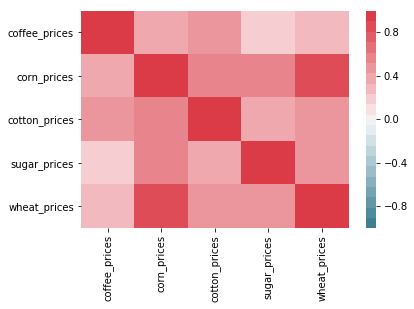

In [221]:
ax = sns.heatmap(
    commodities.corr(),
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(220, 10, n=21)
)

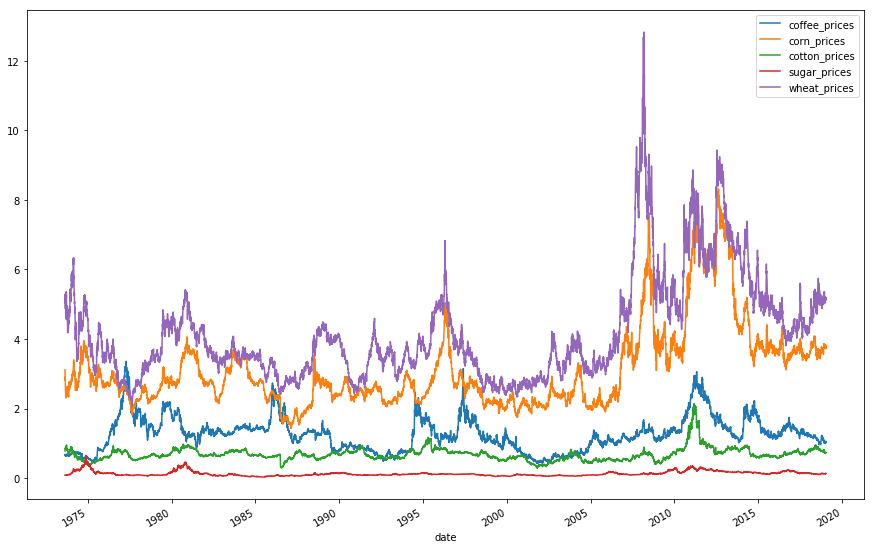

In [222]:
commodities.plot(figsize=(15,10))

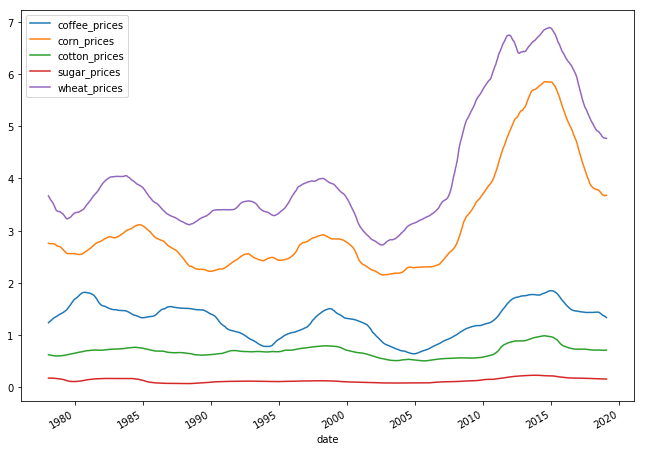

In [223]:
three_year_rolling_mean = commodities.rolling(window=3*365, center=False).mean()
three_year_rolling_mean.plot(figsize=(11,8))

#This is a stationarity time series.  Mean and variance are not evolving over time

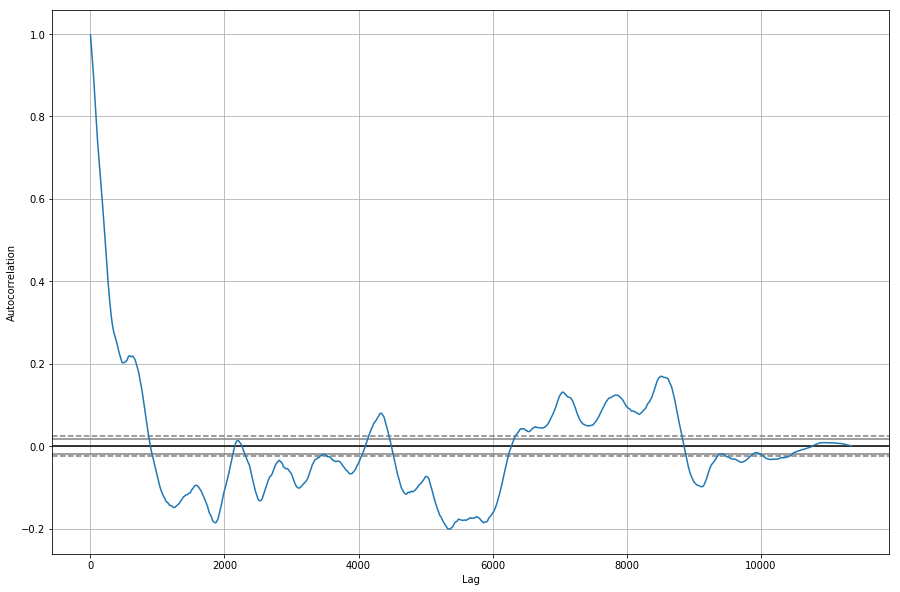

In [224]:
#Autocorrelation analysis
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(15, 10))
autocorrelation_plot(commodities.loc[:, 'coffee_prices'], ax=ax)

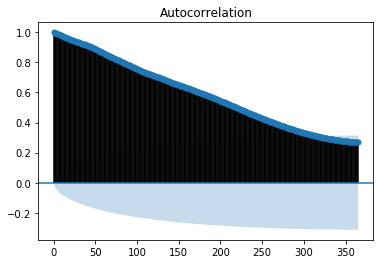

In [225]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

ax = plot_acf(commodities.loc[:, 'coffee_prices'], lags=365 )

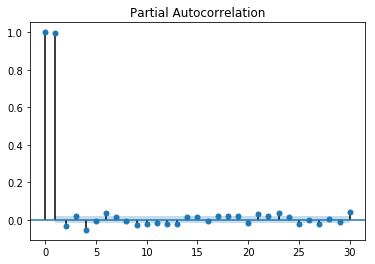

In [226]:
# Plot the partial autocorrelations using statsmodels
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

ax = plot_pacf(commodities.loc[:, 'coffee_prices'], lags=30)

## Model Selection

In [227]:
# Split the Coffee data into train and test
train = coffee.loc['1973': '2007']
test = coffee.loc['2008': '2019']

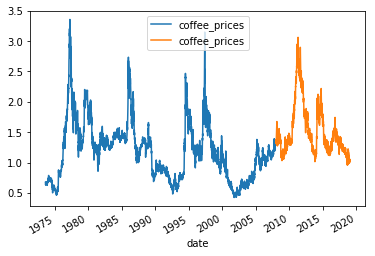

In [228]:
ax = train.plot()
test.plot(ax=ax);

In [ ]:
# Create series of carry-forward predictions

test.loc[:,'baseline_preds'] = train.iloc[-1,0]


In [ ]:
#Graph the Results

test.plot()


In [233]:
# Use RMSE to check the accuracy of our model on the test data set.  This will be the baseline
from sklearn import metrics

np.sqrt(metrics.mean_squared_error(test.loc[:,'coffee_prices'], test.loc[:,'baseline_preds']))

0.4474811759527067

In [ ]:
#Arima Model

sarima = sm.tsa.api.statespace.SARIMAX(train.loc[:,'coffee_prices'], order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
yhat_sarima = sarima.forecast(len(test))



In [ ]:
np.sqrt(metrics.mean_squared_error(test.loc[:,'coffee_prices'], yhat_sarima))

In [ ]:
#Random Forrest Regressor

commodities.loc[:, 'month'] = commodities.index.month
commodities.loc[:, 'day'] = commodities.index.day
commodities.loc[:, 'year'] = commodities.index.year

In [ ]:
commodities = pd.get_dummies(commodities, columns=['month', 'day']).drop(['month_2', 'day_1'], axis=1)

In [ ]:
train = commodities.loc['1973': '2008']
test = commodities.loc['2009': '2019']
X_train = train.iloc[:, 1:]
X_test = test.iloc[:, 1:]
y_train = train.loc[:, 'coffee_prices']
y_test = test.loc[:, 'coffee_prices']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
ax = y_train.plot()
y_test.plot(ax=ax)
pd.Series(y_pred, index=test.index).plot(ax=ax);